Mounted at /content/google_drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn, optim
from torchvision import datasets, transforms

import zipfile

import shutil
import os
import pandas as pd

device = ("cuda" if torch.cuda.is_available() else "cpu") # Use GPU or CPU for training

In [3]:
!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip

--2024-11-14 06:51:32--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.120.96, 52.219.117.128, 52.219.112.120, ...
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.120.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip’

celeba.zip          100%[===================>]   1.34G  45.3MB/s    in 31s     

2024-11-14 06:52:04 (44.6 MB/s) - ‘celeba.zip’ saved [1443490838/1443490838]



In [4]:
with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")

In [5]:
root = 'data_faces/img_align_celeba'
img_list = os.listdir(root)
print(len(img_list))

202599


In [7]:
df = pd.read_csv("list_attr_celeba.csv")
df = df[['image_id', 'Smiling']]

In [8]:
!rm -rf data
!mkdir data && mkdir data/smile && mkdir data/no_smile

In [9]:
s0 = 0
s1 = 0

num = 1500

for i, (_, i_row) in enumerate(df.iterrows()):
  if s0 < num:
    if i_row['Smiling'] == 1:
      s0 += 1
      shutil.copyfile('data_faces/img_align_celeba/' + i_row['image_id'], 'data/smile/' + i_row['image_id'])

  if s1 < num:
    if i_row['Smiling'] == -1:
      s1 += 1
      shutil.copyfile('data_faces/img_align_celeba/' + i_row['image_id'], 'data/no_smile/' + i_row['image_id'])

  if s0 == num and s1 == num:
    break

In [10]:
img_list = os.listdir('data/smile/')
img_list.extend(os.listdir('data/no_smile/'))

In [11]:
print("Images: ", len(img_list))

Images:  3000


In [12]:
!rm -rf 'data/.ipynb_checkpoints/'

In [22]:
transform = transforms.Compose([
          transforms.Resize((28, 28)),
          transforms.ToTensor()
          ])

batch_size = 64
celeba_data = datasets.ImageFolder('data', transform=transform)

In [23]:
print(celeba_data.classes)
print(len(celeba_data))

['no_smile', 'smile']
3000


In [24]:
train_set, test_set = torch.utils.data.random_split(celeba_data, [int(len(img_list) * 0.75), len(img_list) - int(len(img_list) * 0.75)])
train_data_size = len(train_set)
test_data_size = len(test_set)

In [25]:
train_loader= torch.utils.data.DataLoader(train_set,batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

Используется устройство: cpu
Эпоха 1 [0/2250 (0%)]	Потеря: 1647.9883
====> Эпоха 1 Средняя потеря: 1544.8909
====> Тестовая потеря: 1486.6062
Эпоха 2 [0/2250 (0%)]	Потеря: 1454.7012
====> Эпоха 2 Средняя потеря: 1452.3081
====> Тестовая потеря: 1454.1212
Эпоха 3 [0/2250 (0%)]	Потеря: 1426.2764
====> Эпоха 3 Средняя потеря: 1423.4914
====> Тестовая потеря: 1436.8753
Эпоха 4 [0/2250 (0%)]	Потеря: 1428.9001
====> Эпоха 4 Средняя потеря: 1399.7982
====> Тестовая потеря: 1405.9790
Эпоха 5 [0/2250 (0%)]	Потеря: 1372.4987
====> Эпоха 5 Средняя потеря: 1381.2913
====> Тестовая потеря: 1418.8446
Эпоха 6 [0/2250 (0%)]	Потеря: 1386.3450
====> Эпоха 6 Средняя потеря: 1372.6021
====> Тестовая потеря: 1378.2247
Эпоха 7 [0/2250 (0%)]	Потеря: 1425.2427
====> Эпоха 7 Средняя потеря: 1358.5744
====> Тестовая потеря: 1372.0224
Эпоха 8 [0/2250 (0%)]	Потеря: 1390.1367
====> Эпоха 8 Средняя потеря: 1351.4193
====> Тестовая потеря: 1363.3783
Эпоха 9 [0/2250 (0%)]	Потеря: 1393.3977
====> Эпоха 9 Средняя потер

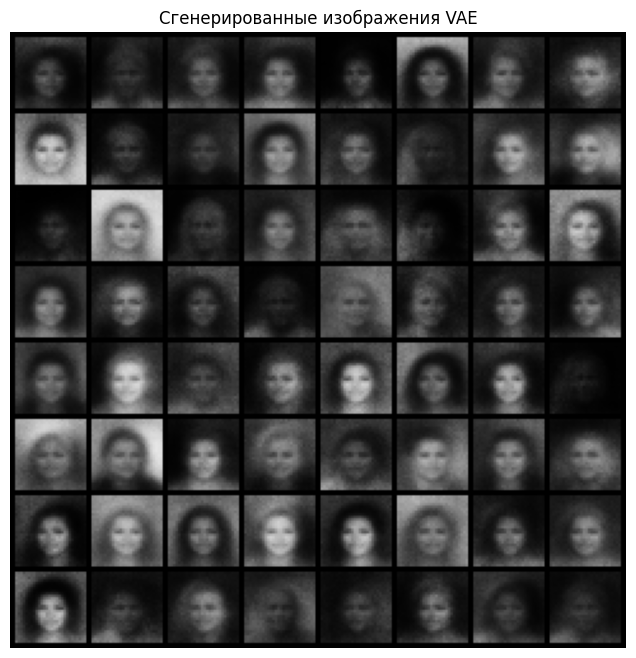

RuntimeError: shape '[64, 1, 28, 28]' is invalid for input of size 150528

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Определение устройства (GPU если доступно, иначе CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используется устройство: {device}")

# Параметры модели
batch_size = 64
latent_dim = 20  # Размер латентного пространства
epochs = 10
learning_rate = 1e-3

# Функция для фильтрации данных
def filter_digits(dataset, digits):
    indices = np.isin(dataset.targets, digits)
    return Subset(dataset, np.where(indices)[0])

# Загрузка набора данных MNIST
transform = transforms.ToTensor()

# Определение архитектуры VAE
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Энкодер
        self.fc1 = nn.Linear(28*28, 400)
        self.fc_mu = nn.Linear(400, latent_dim)      # Среднее
        self.fc_logvar = nn.Linear(400, latent_dim)  # Логарифм дисперсии

        # Декодер
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 28*28)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        mu = self.fc_mu(h1)
        logvar = self.fc_logvar(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)  # Стандартное отклонение
        eps = torch.randn_like(std)  # Случайная нормальная шумовая переменная
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# Функция потерь для VAE
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')

    # Kullback-Leibler дивергенция
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

# Инициализация модели и оптимизатора
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Функция обучения
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f"Эпоха {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} "
                  f"({100. * batch_idx / len(train_loader):.0f}%)]\tПотеря: {loss.item() / len(data):.4f}")

    print(f"====> Эпоха {epoch} Средняя потеря: {train_loss / len(train_loader.dataset):.4f}")

# Функция тестирования
def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon, mu, logvar = model(data)
            test_loss += loss_function(recon, data, mu, logvar).item()

    test_loss /= len(test_loader.dataset)
    print(f"====> Тестовая потеря: {test_loss:.4f}")

# Обучение модели
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)

# Генерация новых изображений
with torch.no_grad():
    z = torch.randn(64, latent_dim).to(device)
    sample = model.decode(z).cpu()

    # Визуализация сгенерированных изображений
    grid_img = torchvision.utils.make_grid(sample.view(64, 1, 28, 28), nrow=8)
    plt.figure(figsize=(8,8))
    plt.imshow(grid_img.permute(1, 2, 0).squeeze(), cmap='gray')
    plt.title("Сгенерированные изображения VAE")
    plt.axis('off')
    plt.show()

# Восстановление изображений из тестового набора
def visualize_reconstructions():
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(test_loader))
        data = data.to(device)
        recon, _, _ = model(data)

        # Выбираем первые 8 изображений
        n = 8
        comparison = torch.cat([data[:n],
                                recon.view(batch_size, 1, 28, 28)[:n]])
        grid_img = torchvision.utils.make_grid(comparison, nrow=n)

        plt.figure(figsize=(16,4))
        plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy(), cmap='gray')
        plt.title("Исходные изображения (верх) и Восстановленные VAE (низ)")
        plt.axis('off')
        plt.show()

visualize_reconstructions()


AttributeError: '_SingleProcessDataLoaderIter' object has no attribute 'next'

AttributeError: '_SingleProcessDataLoaderIter' object has no attribute 'next'

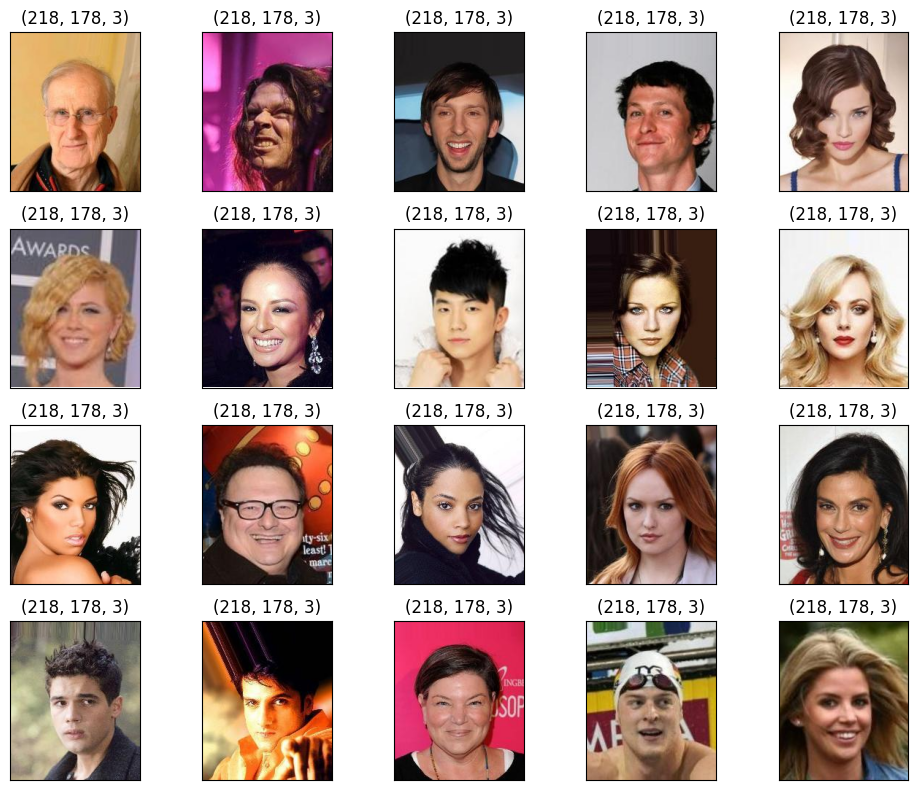

In [ ]:

from glob import glob
from tqdm import tqdm
import tensorflow as tf
import keras
import keras.backend as K
from keras.initializers import RandomNormal
from keras.layers import Dense, Activation, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
filenames = np.array(glob('img_align_celeba/img_align_celeba/*.jpg'))
plt.figure(figsize=(10, 8))
for i in range(20):
    img = plt.imread(filenames[i])
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.title(img.shape)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [ ]:
X_train, X_test = train_test_split(filenames, test_size=1000)

In [ ]:
def load_image(filename, size=(32, 32)):
    img = plt.imread(filename)
    # crop
    rows, cols = img.shape[:2]
    crop_r, crop_c = 150, 150
    start_row, start_col = (rows - crop_r) // 2, (cols - crop_c) // 2
    end_row, end_col = rows - start_row, cols - start_row
    img = img[start_row:end_row, start_col:end_col, :]
    # resize
   # img = np.resize(img, size)
    return img

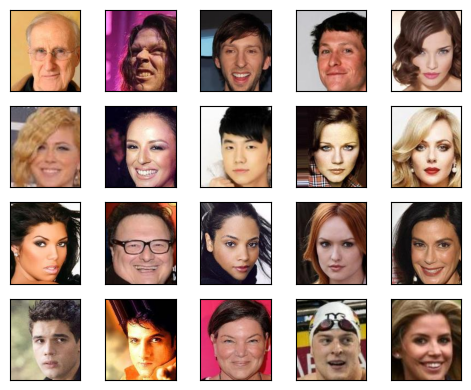

In [ ]:
plt.figure(figsize=(5, 4))
for i in range(20):
    img = load_image(filenames[i])
    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.transforms import *
from torchvision.utils import make_grid
import os
from PIL import Image

class Celeba_Dataset(Dataset):
    def __init__(self, path, max_num_samples = 2000):
        self.folder_path = path
        self.paths_list = os.listdir(self.folder_path)[:max_num_samples]
        self.trans = transforms.Compose([ToTensor(), Resize((64, 64)), Normalize(0, 1)])

    def __len__(self):
        return len(self.paths_list)

    def __getitem__(self, index):
        img_name = self.paths_list[index]
        img_path = os.path.join(self.folder_path, img_name)
        img_pil = Image.open(img_path)
        return self.trans(img_pil)


In [ ]:
dataset = Celeba_Dataset('img_align_celeba/img_align_celeba')
train_loader = DataLoader(dataset, batch_size = 32, shuffle = True)
a = next(iter(train_loader))
a.shape

torch.Size([32, 3, 64, 64])

In [ ]:
torch.Size([32, 3, 64, 64])

torch.Size([32, 3, 64, 64])

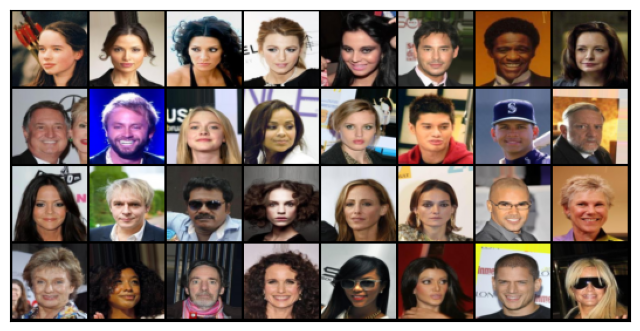

In [ ]:
def show_images(a, N = 32):
    plt.figure(1, (8, 8))
    grid = make_grid(a[:N])
    grid = grid.numpy().transpose((1, 2, 0))
    plt.imshow(grid)
    plt.xticks([])
    plt.yticks([])
    plt.show()
show_images(a)